In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import pickle


import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
pd.set_option('display.max_columns', 500)

In [2]:
last_n_dict = pickle.load(open("last_n_dict.p", "rb" ))

In [3]:
def get_Xy_linreg(data_dict, n=5):
    data = data_dict[n]
    x = data.loc[:,'days_off':].drop('above_avg_fscore',1)
    x['home'] = data.home
    y = data.fscore
    return x,y

def year_train_test(data_dict, n=5, year = 2017):
    data = data_dict[n]
    x_train = data.loc[:,'days_off':].loc[data.season != year].drop('above_avg_fscore',1)
    x_train['home'] = data.home.loc[data.season != year]
    y_train = data.loc[data.season != year].fscore

    x_test = data.loc[:,'days_off':].loc[data.season == year].drop('above_avg_fscore',1)
    x_test['home'] = data.home.loc[data.season == year]
    y_test = data.loc[data.season == year].fscore
    
    return x_train, x_test, y_train, y_test

def get_kbest(X,y,score_func = f_regression, k = 10):    
    X_scaled = StandardScaler().fit_transform(X)
    kbest = SelectKBest(score_func, k=k)
    kbest.fit(X_scaled,y)
    kbest_fts = []
    for label in X.columns[kbest.get_support()]:
        kbest_fts.append(label)
    return kbest_fts

In [4]:
kbest_fts = {} 
for n in last_n_dict:
    X,y = get_Xy_linreg(last_n_dict, n=n)
    kbest_fts[n] = get_kbest(X,y,k=10)
kbest_df = pd.DataFrame(kbest_fts)
kbest_df

,1,3,5,7,10,15,20
0,fscore_exp,fscore_exp,fscore_exp,fscore_exp,fscore_exp,fscore_exp,fscore_exp
1,mp_l1,mp_l3,mp_l5,mp_l7,mp_l10,mp_l15,mp_l20
2,fgm_l1,fgm_l3,fgm_l5,fgm_l7,fgm_l10,fgm_l15,fgm_l20
3,fga_l1,fga_l3,fga_l5,fga_l7,fga_l10,fga_l15,fga_l20
4,ftm_l1,ftm_l3,ftm_l5,ftm_l7,ftm_l10,ftm_l15,ftm_l20
5,fta_l1,fta_l3,fta_l5,fta_l7,fta_l10,fta_l15,fta_l20
6,dreb_l1,dreb_l3,dreb_l5,dreb_l7,ft_pct_l10,ft_pct_l15,ft_pct_l20
7,reb_l1,tov_l3,tov_l5,tov_l7,tov_l10,tov_l15,tov_l20
8,pts_l1,pts_l3,pts_l5,pts_l7,pts_l10,pts_l15,pts_l20
9,fscore_l1,fscore_l3,fscore_l5,fscore_l7,fscore_l10,fscore_l15,fscore_l20


In [5]:
fts_picked = ['mp_l', 'pts_l','ast_l','reb_l','stl_l','blk_l','tov_l','fg3m_l','opp_def_eff_l','tm_pace_l', 'home']
fts_picked_dict = {n:[x+str(n) if x != 'home' else x for x in fts_picked] for n in last_n_dict}
fts_picked_dict[5]

['mp_l5',
 'pts_l5',
 'ast_l5',
 'reb_l5',
 'stl_l5',
 'blk_l5',
 'tov_l5',
 'fg3m_l5',
 'opp_def_eff_l5',
 'tm_pace_l5',
 'home']

In [6]:
def avg_score(X,y, model,score="neg_mean_squared_error", cv=5):
    scores = cross_val_score(model, X, y,
                             scoring=score, cv=cv)
    if score == "neg_mean_squared_error":
        scores = np.sqrt(-scores)
    return scores.mean()

def scaled_ols(degree = 1):
    sc_ols = Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree)),
        ("ridge", LinearRegression()),
        ]) 
    return sc_ols

def scaled_ridge(alpha = 1 ,degree = 1):
    sc_ridge = Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree)),
        ("ridge", Ridge(alpha = alpha)),
        ]) 
    return sc_ridge

def scaled_lasso(alpha = 1, degree = 1):
    sc_ridge = Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree)),        
        ("ridge", Lasso(alpha = alpha)),
        ]) 
    return sc_ridge



In [69]:
X_train = {}
X_test = {}
X_train_kb = {}
X_test_kb = {}
X_train_p = {}
X_test_p = {}
y_train = {}
y_test = {}
for n in last_n_dict:
    X_train[n],X_test[n],y_train[n],y_test[n] = year_train_test(last_n_dict, year = 2017, n=n)
    X_train_kb[n],X_test_kb[n] = X_train[n][kbest_fts[n]],X_test[n][kbest_fts[n]]
    X_train_p[n],X_test_p[n] = X_train[n][fts_picked_dict[n]],X_test[n][fts_picked_dict[n]]

In [46]:
ols_means_train = {}
ols_means_test = {}
for n in last_n_dict:
    rmse_train = avg_score(X_train_kb[n],y_train[n],scaled_ols())
    rmse_test = avg_score(X_test_kb[n],y_test[n],scaled_ols())
    ols_means_train[n] = (rmse_train)
    ols_means_test[n] = (rmse_test)

ols_df_train = pd.DataFrame(ols_means_train, index = ['ols_train']).T
ols_df_test = pd.DataFrame(ols_means_test, index = ['ols_test']).T
rmse_df_kb = pd.concat([ols_df_train,ols_df_test], axis = 1)
rmse_df_kb


,ols_train,ols_test
1,9.432398,9.423937
3,9.365836,9.352333
5,9.360033,9.348744
7,9.365096,9.359807
10,9.381708,9.372892
15,9.409444,9.408252
20,9.437600,9.434441


In [47]:
ols_means_train = {}
ols_means_test = {}
for n in last_n_dict:
    rmse_train = avg_score(X_train_p[n],y_train[n],scaled_ols())
    rmse_test = avg_score(X_test_p[n],y_test[n],scaled_ols())
    ols_means_train[n] = (rmse_train)
    ols_means_test[n] = (rmse_test)

ols_df_train = pd.DataFrame(ols_means_train, index = ['ols_train']).T
ols_df_test = pd.DataFrame(ols_means_test, index = ['ols_test']).T
rmse_df_p = pd.concat([ols_df_train,ols_df_test], axis = 1)
rmse_df_p

,ols_train,ols_test
1,10.593620,10.601052
3,9.812464,9.798975
5,9.620792,9.615975
7,9.543132,9.553289
10,9.504331,9.510566
15,9.501312,9.516957
20,9.529071,9.546412


In [50]:
ridge_means_train = {}
ridge_means_test = {}
for n in last_n_dict:
    rmse_train = avg_score(X_train_kb[n],y_train[n],scaled_ridge(),cv=5)
    rmse_test = avg_score(X_test_kb[n],y_test[n],scaled_ridge(),cv=5)
    ridge_means_train[n] = (rmse_train)
    ridge_means_test[n] = (rmse_test)

ridge_df_train = pd.DataFrame(ridge_means_train, index = ['ridge_train']).T
ridge_df_test = pd.DataFrame(ridge_means_test, index = ['ridge_test']).T
rmse_df_kb = pd.concat([rmse_df_kb,ridge_df_train,ridge_df_test], axis = 1)
rmse_df_kb


,ols_train,ols_test,ridge_train,ridge_test
1,9.432398,9.423937,9.432398,9.423930
3,9.365836,9.352333,9.365835,9.352326
5,9.360033,9.348744,9.360032,9.348738
7,9.365096,9.359807,9.365095,9.359800
10,9.381708,9.372892,9.381708,9.372880
15,9.409444,9.408252,9.409444,9.408220
20,9.437600,9.434441,9.437600,9.434393


In [51]:
ridge_means_train = {}
ridge_means_test = {}
for n in last_n_dict:
    rmse_train = avg_score(X_train_p[n],y_train[n],scaled_ridge(),cv=5)
    rmse_test = avg_score(X_test_p[n],y_test[n],scaled_ridge(),cv=5)
    ridge_means_train[n] = (rmse_train)
    ridge_means_test[n] = (rmse_test)

ridge_df_train = pd.DataFrame(ridge_means_train, index = ['ridge_train']).T
ridge_df_test = pd.DataFrame(ridge_means_test, index = ['ridge_test']).T
rmse_df_p = pd.concat([rmse_df_p,ridge_df_train,ridge_df_test], axis = 1)
rmse_df_p


,ols_train,ols_test,ridge_train,ridge_test
1,10.593620,10.601052,10.593620,10.601051
3,9.812464,9.798975,9.812464,9.798975
5,9.620792,9.615975,9.620792,9.615975
7,9.543132,9.553289,9.543132,9.553289
10,9.504331,9.510566,9.504331,9.510566
15,9.501312,9.516957,9.501312,9.516957
20,9.529071,9.546412,9.529071,9.546411


In [52]:
lasso_means_train = {}
lasso_means_test = {}
for n in last_n_dict:
    rmse_train = avg_score(X_train_kb[n],y_train[n],scaled_lasso(),cv=5)
    rmse_test = avg_score(X_test_kb[n],y_test[n],scaled_lasso(),cv=5)
    lasso_means_train[n] = (rmse_train)
    lasso_means_test[n] = (rmse_test)

lasso_df_train = pd.DataFrame(lasso_means_train, index = ['lasso_train']).T
lasso_df_test = pd.DataFrame(lasso_means_test, index = ['lasso_test']).T
rmse_df_kb = pd.concat([rmse_df_kb,lasso_df_train,lasso_df_test], axis = 1)
rmse_df_kb


,ols_train,ols_test,ridge_train,ridge_test,lasso_train,lasso_test
1,9.432398,9.423937,9.432398,9.423930,9.504568,9.496406
3,9.365836,9.352333,9.365835,9.352326,9.445799,9.438040
5,9.360033,9.348744,9.360032,9.348738,9.434975,9.428140
7,9.365096,9.359807,9.365095,9.359800,9.436364,9.431789
10,9.381708,9.372892,9.381708,9.372880,9.446511,9.437335
15,9.409444,9.408252,9.409444,9.408220,9.468973,9.467752
20,9.437600,9.434441,9.437600,9.434393,9.495126,9.492944


In [53]:
lasso_means_train = {}
lasso_means_test = {}
for n in last_n_dict:
    rmse_train = avg_score(X_train_p[n],y_train[n],scaled_lasso(),cv=5)
    rmse_test = avg_score(X_test_p[n],y_test[n],scaled_lasso(),cv=5)
    lasso_means_train[n] = (rmse_train)
    lasso_means_test[n] = (rmse_test)

lasso_df_train = pd.DataFrame(lasso_means_train, index = ['lasso_train']).T
lasso_df_test = pd.DataFrame(lasso_means_test, index = ['lasso_test']).T
rmse_df_p = pd.concat([rmse_df_p,lasso_df_train,lasso_df_test], axis = 1)
rmse_df_p

,ols_train,ols_test,ridge_train,ridge_test,lasso_train,lasso_test
1,10.593620,10.601052,10.593620,10.601051,10.752367,10.752141
3,9.812464,9.798975,9.812464,9.798975,9.962610,9.925484
5,9.620792,9.615975,9.620792,9.615975,9.769589,9.738204
7,9.543132,9.553289,9.543132,9.553289,9.695275,9.672675
10,9.504331,9.510566,9.504331,9.510566,9.658544,9.629812
15,9.501312,9.516957,9.501312,9.516957,9.655845,9.635474
20,9.529071,9.546412,9.529071,9.546411,9.684158,9.661374


In [54]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
def scaled_tree():
    sc_tree = Pipeline([
        ("scaler", StandardScaler()),
        ("tree", DecisionTreeRegressor()),
        ]) 
    return sc_tree

def scaled_forest(max_depth = 2):
    sc_forest = Pipeline([
        ("scaler", StandardScaler()),
        ("tree", RandomForestRegressor(max_depth=max_depth)),
        ]) 
    return sc_forest

In [55]:
tree_means_train = {}
tree_means_test = {}
for n in last_n_dict:
    rmse_train = avg_score(X_train_kb[n],y_train[n],scaled_tree(),cv=5)
    rmse_test = avg_score(X_test_kb[n],y_test[n],scaled_tree(),cv=5)
    tree_means_train[n] = (rmse_train)
    tree_means_test[n] = (rmse_test)

tree_df_train = pd.DataFrame(tree_means_train, index = ['tree_train']).T
tree_df_test = pd.DataFrame(tree_means_test, index = ['tree_test']).T
rmse_df_kb = pd.concat([rmse_df_kb,tree_df_train,tree_df_test], axis = 1)
rmse_df_kb


,ols_train,ols_test,ridge_train,ridge_test,lasso_train,lasso_test,tree_train,tree_test
1,9.432398,9.423937,9.432398,9.423930,9.504568,9.496406,13.769615,13.792870
3,9.365836,9.352333,9.365835,9.352326,9.445799,9.438040,13.729015,13.747288
5,9.360033,9.348744,9.360032,9.348738,9.434975,9.428140,13.751196,13.921481
7,9.365096,9.359807,9.365095,9.359800,9.436364,9.431789,13.820169,13.939535
10,9.381708,9.372892,9.381708,9.372880,9.446511,9.437335,13.873281,14.162114
15,9.409444,9.408252,9.409444,9.408220,9.468973,9.467752,14.002799,14.284953
20,9.437600,9.434441,9.437600,9.434393,9.495126,9.492944,14.090772,14.396226


In [56]:
tree_means_train = {}
tree_means_test = {}
for n in last_n_dict:
    rmse_train = avg_score(X_train_p[n],y_train[n],scaled_tree(),cv=5)
    rmse_test = avg_score(X_test_p[n],y_test[n],scaled_tree(),cv=5)
    tree_means_train[n] = (rmse_train)
    tree_means_test[n] = (rmse_test)

tree_df_train = pd.DataFrame(tree_means_train, index = ['tree_train']).T
tree_df_test = pd.DataFrame(tree_means_test, index = ['tree_test']).T
rmse_df_p = pd.concat([rmse_df_p,tree_df_train,tree_df_test], axis = 1)
rmse_df_p

,ols_train,ols_test,ridge_train,ridge_test,lasso_train,lasso_test,tree_train,tree_test
1,10.593620,10.601052,10.593620,10.601051,10.752367,10.752141,15.399055,15.532806
3,9.812464,9.798975,9.812464,9.798975,9.962610,9.925484,14.341132,14.460830
5,9.620792,9.615975,9.620792,9.615975,9.769589,9.738204,14.145577,14.192733
7,9.543132,9.553289,9.543132,9.553289,9.695275,9.672675,14.059812,14.016581
10,9.504331,9.510566,9.504331,9.510566,9.658544,9.629812,14.130930,14.190924
15,9.501312,9.516957,9.501312,9.516957,9.655845,9.635474,14.257261,14.228241
20,9.529071,9.546412,9.529071,9.546411,9.684158,9.661374,14.397789,14.381092


In [57]:
forest_means_train = {}
forest_means_test = {}
for n in last_n_dict:
    rmse_train = avg_score(X_train_kb[n],y_train[n],scaled_forest(),cv=5)
    rmse_test = avg_score(X_test_kb[n],y_test[n],scaled_forest(),cv=5)
    forest_means_train[n] = (rmse_train)
    forest_means_test[n] = (rmse_test)

forest_df_train = pd.DataFrame(forest_means_train, index = ['forest_train']).T
forest_df_test = pd.DataFrame(forest_means_test, index = ['forest_test']).T
rmse_df_kb = pd.concat([rmse_df_kb,forest_df_train,forest_df_test], axis = 1)
rmse_df_kb


,ols_train,ols_test,ridge_train,ridge_test,lasso_train,lasso_test,tree_train,tree_test,forest_train,forest_test
1,9.432398,9.423937,9.432398,9.423930,9.504568,9.496406,13.769615,13.792870,10.016866,9.905068
3,9.365836,9.352333,9.365835,9.352326,9.445799,9.438040,13.729015,13.747288,10.004357,9.913258
5,9.360033,9.348744,9.360032,9.348738,9.434975,9.428140,13.751196,13.921481,9.978022,9.882173
7,9.365096,9.359807,9.365095,9.359800,9.436364,9.431789,13.820169,13.939535,9.911670,9.875239
10,9.381708,9.372892,9.381708,9.372880,9.446511,9.437335,13.873281,14.162114,9.951670,9.824104
15,9.409444,9.408252,9.409444,9.408220,9.468973,9.467752,14.002799,14.284953,9.921099,9.901394
20,9.437600,9.434441,9.437600,9.434393,9.495126,9.492944,14.090772,14.396226,9.944842,9.961960


In [58]:
forest_means_train = {}
forest_means_test = {}
for n in last_n_dict:
    rmse_train = avg_score(X_train_p[n],y_train[n],scaled_forest(),cv=5)
    rmse_test = avg_score(X_test_p[n],y_test[n],scaled_forest(),cv=5)
    forest_means_train[n] = (rmse_train)
    forest_means_test[n] = (rmse_test)

forest_df_train = pd.DataFrame(forest_means_train, index = ['forest_train']).T
forest_df_test = pd.DataFrame(forest_means_test, index = ['forest_test']).T
rmse_df_p = pd.concat([rmse_df_p,forest_df_train,forest_df_test], axis = 1)
rmse_df_p

,ols_train,ols_test,ridge_train,ridge_test,lasso_train,lasso_test,tree_train,tree_test,forest_train,forest_test
1,10.593620,10.601052,10.593620,10.601051,10.752367,10.752141,15.399055,15.532806,11.233325,11.405555
3,9.812464,9.798975,9.812464,9.798975,9.962610,9.925484,14.341132,14.460830,10.617135,10.679961
5,9.620792,9.615975,9.620792,9.615975,9.769589,9.738204,14.145577,14.192733,10.494153,10.598532
7,9.543132,9.553289,9.543132,9.553289,9.695275,9.672675,14.059812,14.016581,10.441388,10.515698
10,9.504331,9.510566,9.504331,9.510566,9.658544,9.629812,14.130930,14.190924,10.422918,10.433071
15,9.501312,9.516957,9.501312,9.516957,9.655845,9.635474,14.257261,14.228241,10.405058,10.441194
20,9.529071,9.546412,9.529071,9.546411,9.684158,9.661374,14.397789,14.381092,10.369019,10.436327


In [8]:
#pickle.dump(rmse_df_kb, open('rmse_df_kb.p','wb'))
#pickle.dump(rmse_df_p, open('rmse_df_p.p','wb'))

#pickle.dump(all_fts_df, open('all_fts_df.p','wb'))
rmse_df_kb = pickle.load(open("rmse_df_kb.p", "rb" ))
rmse_df_p = pickle.load(open("rmse_df_p.p", "rb" ))

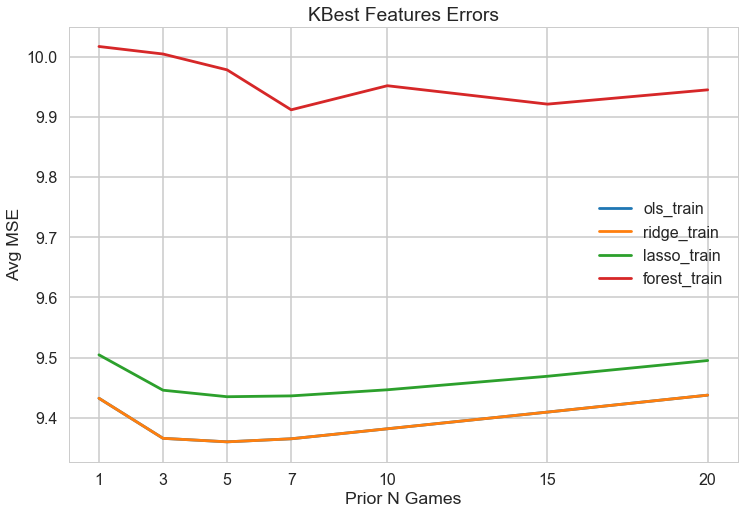

In [45]:
plt.figure(figsize=(12,8))
for x in rmse_df_kb.columns:
    if ('train' in x) & ('tree' not in x):
        plt.plot(rmse_df_kb[x], label = x)

plt.title('KBest Features Errors')
plt.xlabel('Prior N Games')
plt.ylabel('Avg MSE')
plt.legend()
plt.xticks([1,3,5,7,10,15,20])
plt.show()

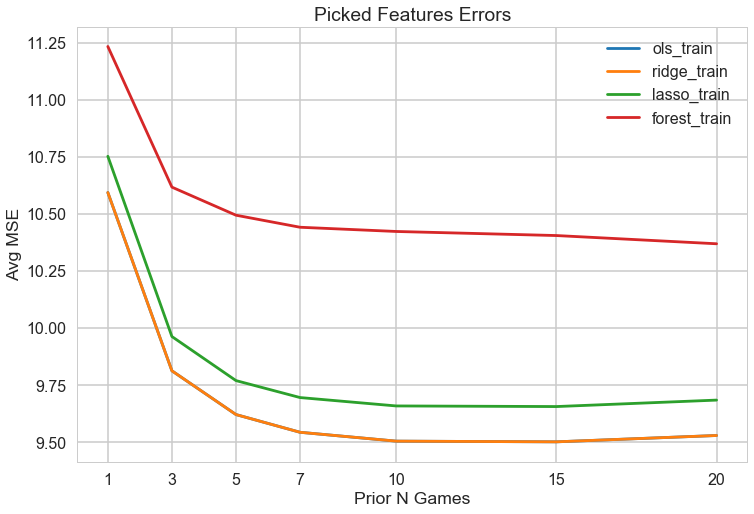

In [46]:
plt.figure(figsize=(12,8))
for x in rmse_df_p.columns:
    if ('train' in x) & ('tree' not in x):
        plt.plot(rmse_df_p[x])

plt.title('Picked Features Errors')
plt.xlabel('Prior N Games')
plt.ylabel('Avg MSE')
plt.legend()
plt.xticks([1,3,5,7,10,15,20])
plt.show()


In [9]:
X5, X5_test, y5, y5_test = X_train[5], X_test[5], y_train[5], y_test[5]

In [62]:
from sklearn.model_selection import GridSearchCV

# Create the classifier: logreg
ridge = scaled_ridge()
alphas = [.01,.1,1,10]

param_grid = [
    {'ridge__alpha':alphas}
  ]

grid_search = GridSearchCV(ridge, param_grid, scoring = 'neg_mean_squared_error')
                           
grid_search.fit(X5, y5)
grid_search.best_params_

{'ridge__alpha': 0.1}

In [76]:
ridge_best = grid_search.best_estimator_
avg_score(X5_test,y5_test,ridge_best,cv=5)

9.333491214485274

In [81]:
ridge_best.fit(X5,y5)
y_pred = ridge_best.predict(X5_test)

In [82]:
last5 = last_n_dict[5]
harden17 = last5.loc[(last5.player_name == 'James Harden') & (last5.season ==2017)].fscore
real_pred = pd.DataFrame(list(zip(y_pred,y5_test)), index = y5_test.index, columns = ['pred','test'])

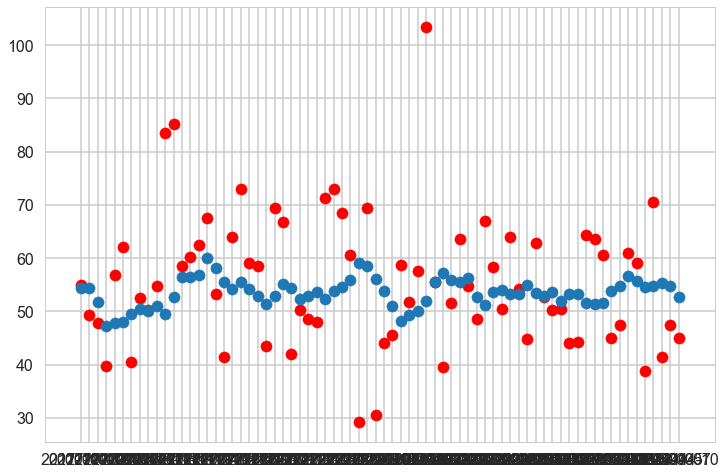

In [83]:
plt.figure(figsize=(12,8))
plt.scatter(last5.loc[harden17.index].game_date,harden17, c = 'red')
plt.scatter(last5.loc[harden17.index].game_date,real_pred.loc[harden17.index].pred)
plt.show()

In [84]:
np.mean(np.abs(real_pred.loc[harden17.index].pred - harden17))

9.739025939709233

In [99]:
def player_fscores(data, player, year = 2017):
    plyr_data = data.loc[(data.player_name == player) & (last5.season == year)].fscore
    return plyr_data

def avg_diff(player):
    diff = np.mean(np.abs(real_pred.loc[plyr_fscores[player].index].pred - plyr_fscores[player]))
    return diff

In [198]:
def plyr_plot(data, player):
    plt.clf()
    plyr_data = player_fscores(data, player)
    pred = real_pred.loc[plyr_data.index].pred
    game_count = data.loc[plyr_data.index].game_count
    plt.figure(figsize=(12,8))
    plt.scatter(game_count,plyr_data, c = 'red', label = 'Actual')
    plt.scatter(game_count,pred, label = 'Predicted')
    plt.title(str(player)+ ' Actual vs. Predicted Fantasy Scores 2017')
    plt.xlabel('Game Count')
    plt.ylabel('Fantasy Score')
    plt.legend()
    plt.show()
    
def plyr_resplot(data, player):
    plt.clf()
    plyr_data = player_fscores(data, player)
    pred = real_pred.loc[plyr_data.index].pred
    game_count = list(data.loc[plyr_data.index].game_count)
    plt.figure(figsize=(12,8))
    plt.scatter(game_count,(plyr_data-pred), label = 'Actual')
    plt.title(str(player)+ ' Actual vs. Predicted Residual Plot 2017')
    plt.axhline(y = 0, linestyle = 'dashed')
    plt.xlabel('Game Count')
    plt.ylabel('Actual - Predicted Fscore')
    plt.show()

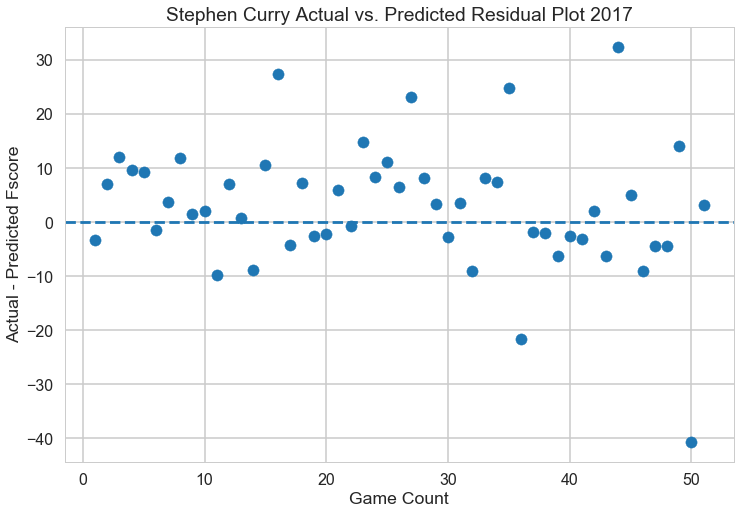

In [202]:
plyr_resplot(last5,'Stephen Curry')

In [203]:
players = last5.player_name.unique()
plyr_fscores = {p:player_fscores(last5, p) for p in players}

In [211]:
avg_diffs = {p:[avg_diff(p),np.std(plyr_fscores[p]),np.mean(plyr_fscores[p])] for p in players}
avg_diffs = {k: v for k, v in avg_diffs.items() if np.isfinite(v[0])}

In [212]:
avg_diffs_df = pd.DataFrame.from_dict(avg_diffs,orient='index')
avg_diffs_df.columns = ['avg_diff', 'fscore_std','avg_fscore']
avg_diffs_df.sort_values('avg_diff', ascending = False,inplace =True)
avg_diffs_df[:10]

,avg_diff,fscore_std,avg_fscore
Anthony Davis,12.617262,15.722370,54.020000
Nikola Jokic,11.891398,14.593531,45.536667
Rajon Rondo,11.130151,13.822423,27.765385
LeBron James,11.117405,13.737475,56.887195
Devin Booker,10.973059,12.811978,39.537037
D'Angelo Russell,10.870212,13.134561,30.015625
Nikola Vucevic,10.568266,13.466501,37.530702
Nikola Mirotic,10.567980,12.451307,31.013636
Dwight Howard,10.519608,12.678648,38.314815
Andre Drummond,10.494522,12.013915,45.644231


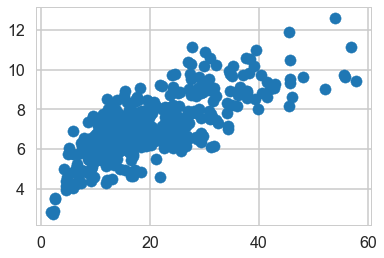

In [215]:
plt.scatter(avg_diffs_df.avg_fscore,avg_diffs_df.avg_diff)
plt.show()

In [207]:
np.std(plyr_fscores['Devin Booker'])

12.811977849108064

## Logistic Regression

In [80]:
def szn_train_test_log(data_dict, n = 5, year = 2017):
    data = data_dict[n]
    X = data.loc[:,'days_off':].loc[data.season == year].drop('above_avg_fscore',1)
    X['home'] = data.home.loc[data.season == year]
    y = data.loc[data.season == year].above_avg_fscore
    return train_test_split(X,y, test_size = .2, random_state=1)

def plyr_train_test_log(data_dict, player, n = 5):
    data = data_dict[n]
    player_df = data.loc[data.player_name == player]
    X = player_df.loc[:,'days_off':].drop('above_avg_fscore',1)
    X['home'] = data.home.loc[data.player_name == player]
    y = player_df.above_avg_fscore
    
    return train_test_split(X,y, test_size = .2, random_state=1)

def year_train_test_log(data_dict, n=5, year = 2017):
    data = data_dict[n]
    x_train = data.loc[:,'days_off':].loc[data.season != year].drop('above_avg_fscore',1)
    x_train['home'] = data.home.loc[data.season != year]
    y_train = data.loc[data.season != year].above_avg_fscore

    x_test = data.loc[:,'days_off':].loc[data.season == year].drop('above_avg_fscore',1)
    x_test['home'] = data.home.loc[data.season == year]
    y_test = data.loc[data.season == year].above_avg_fscore
    
    return x_train, x_test, y_train, y_test

def scaled_log(C=1, penalty='l2'):
    sc_log = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(C=C, penalty='l2')),
        ]) 
    return sc_log

In [118]:
# Import the necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
n = 5
# Create training and test sets
X_train, X_test, y_train, y_test = year_train_test_log(last_n_dict, n = n)
X_train = X_train[kbest_fts[n]]
X_test = X_test[kbest_fts[n]]

# Create the classifier: logreg
logreg = scaled_log()

# Fit the classifier to the training data
logreg.fit(X_train,y_train)

# Predict the labels of the test set: y_pred

y_pred = logreg.predict(X_train)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

[[148354  63284]
 [110932  82630]]
             precision    recall  f1-score   support

          0       0.57      0.70      0.63    211638
          1       0.57      0.43      0.49    193562

avg / total       0.57      0.57      0.56    405200



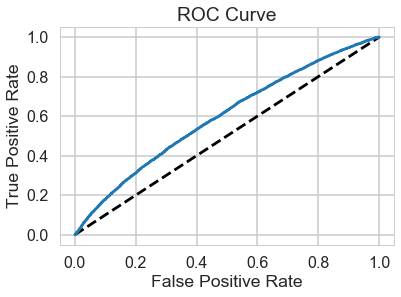

In [119]:
from sklearn.metrics import roc_curve

# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [120]:


# Import necessary modules
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(logreg,X_train,y_train,cv=10,scoring='roc_auc')

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC: 0.595058649709576
AUC scores computed using 5-fold cross-validation: [0.60701287 0.59507922 0.60645355 0.601752   0.58882465 0.59304879
 0.59852302 0.58712812 0.5983646  0.59317593]


In [122]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

for key in last_n_dict:
    X_train,X_test,y_train,y_test = year_train_test_log(last_n_dict, year = 2017, n=key)
    X_train,X_test = X_train[kbest_fts[key]],X_test[kbest_fts[key]]
    # Create the classifier: logreg
    logreg = scaled_log()

    # Fit the classifier to the training data
    logreg.fit(X_train,y_train)

    # Predict the labels of the test set: y_pred

    y_pred = logreg.predict(X_test)
    
    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = logreg.predict_proba(X_test)[:,1]

    # Compute and print AUC score
    print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))



AUC: 0.5830729640949378
AUC: 0.5950832033708173
AUC: 0.595058649709576
AUC: 0.5921498198228647
AUC: 0.5892937217240997
AUC: 0.5823683918285363
AUC: 0.5754729653824922


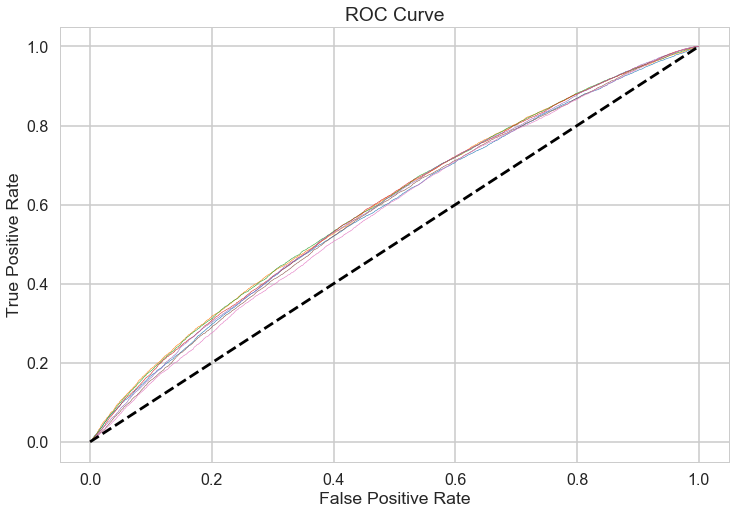

In [123]:
from sklearn.metrics import roc_curve
plt.figure(figsize= (12,8)) 
for key in last_n_dict:    
    X_train,X_test,y_train,y_test = year_train_test_log(last_n_dict, year = 2017, n=key)
    X_train,X_test = X_train[kbest_fts[key]],X_test[kbest_fts[key]]
    # Create the classifier: logreg
    logreg = scaled_log()

    # Fit the classifier to the training data
    logreg.fit(X_train,y_train)

    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = logreg.predict_proba(X_test)[:,1]

    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Plot ROC curve
    plt.plot(fpr, tpr, linewidth = .5)
  
plt.plot([0, 1], [0, 1], 'k--')    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [124]:
from sklearn.model_selection import GridSearchCV

X_train,X_test,y_train,y_test = szn_train_test_log(last_n_dict, year = 2017, n=5)
X_train,X_test = X_train[kbest_fts[5]],X_test[kbest_fts[5]]

# Create the classifier: logreg
logreg = scaled_log()

cspace = np.logspace(-3,8,20)
param_grid = [
    {'logreg__C': cspace, 'logreg__penalty' : ['l1','l2']}
  ]

grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring = 'roc_auc')
                           
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'logreg__C': 2335.7214690901214, 'logreg__penalty': 'l1'}

In [125]:
# Import necessary modules
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

# Compute predicted probabilities: y_pred_prob
y_pred_prob = grid_search.best_estimator_.predict_proba(X_test)[:,1]

# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(grid_search.best_estimator_,X_train,y_train,cv=5,scoring='roc_auc')

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC: 0.5909441304459779
AUC scores computed using 5-fold cross-validation: [0.58756152 0.6133444  0.59755209 0.5878158  0.58707486]


In [117]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
X_train,X_test,y_train,y_test = szn_train_test_log(last_n_dict, year = 2017, n=5)
X_train,X_test = X_train[kbest_fts[5]],X_test[kbest_fts[5]]
svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(3)),
        ("linear_svc", LinearSVC(C=1, loss="hinge")),
    ])

svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)

# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred)))

AUC: 0.5482203207075909


In [110]:
from sklearn.svm import SVC
X_train,X_test,y_train,y_test = szn_train_test_log(last_n_dict, year = 2017, n=5)
X_train,X_test = X_train[kbest_fts[5]],X_test[kbest_fts[5]]
svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(C=3)),
    ])

svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)

# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred)))

AUC: 0.5520073192398806


In [103]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

for key in last_n_dict:
    X_train,X_test,y_train,y_test = plyr_train_test_log(last_n_dict, player = 'LeBron James', n=key)
    X_train,X_test = X_train[kbest_fts[key]],X_test[kbest_fts[key]]
    # Create the classifier: logreg
    logreg = scaled_log()

    # Fit the classifier to the training data
    logreg.fit(X_train,y_train)

    # Predict the labels of the test set: y_pred

    y_pred = logreg.predict(X_test)
    
    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = logreg.predict_proba(X_test)[:,1]

    # Compute and print AUC score
    print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))



AUC: 0.5467836257309941
AUC: 0.5398584179747614
AUC: 0.572406894429055
AUC: 0.5510156971375808
AUC: 0.5676361957525393
AUC: 0.5323176361957526
AUC: 0.5697907048322561
